In [1]:
# Import libraries/data
import numpy as np
import pandas as pd
import reverse_geocode
import datetime # allows us to get current timestamp in ISO format (as used in the .csv file)
import matplotlib.pyplot as plt

In [2]:
# Name the data
earthquake_data = pd.read_csv('earthquakes.csv')
magnitude = np.array(earthquake_data['mag'])

In [3]:
# Create a report on all earthquakes that occurred globally in the past 30 days

# None occurred in the past 30 days, so test 1 year and 30 days ago ( 01/14/2020 )

# Get current timestamp
current = datetime.datetime.utcnow().replace().isoformat()[:-3] # converts to string, but will fix later
print('current:',current)

df = pd.DataFrame(earthquake_data) # time is in form '2020-04-10T20:21:18.360Z'
past30Data = df.loc[df['time'] > '2020-01-14T00:00:00.000Z', ['mag','magType','longitude','latitude', "time"]].to_numpy()
# [ 0: mag, 1: magType, 2: longitude, 3: latitude, 4: time]

# Turn into dictionary
past30DataArr = []
c = 0

for row in past30Data:
    # for each row in the array
    col_data = {
            "mag": row[0],
            "magType": row[1],
            "lon": row[2],
            "lat": row[3],
            "time": row[4]
    }
    
    # append to array
    past30DataArr.append(col_data)

current: 2021-02-14T06:56:44.827


In [4]:
# Compute basic stats on the magnitude: max, min, median, mean, and 25th and 75th percentiles

# Extract all magnitudes from the filtered data
mag_data_arr = []

for i in past30DataArr: 
    mag_data_arr.append(i.get("mag"))

magMax = np.nanmax(mag_data_arr)
magMin = np.nanmin(mag_data_arr)
magMed = np.nanmedian(mag_data_arr)
magMean = np.nanmean(mag_data_arr)
mag25 = np.nanpercentile(mag_data_arr,25)
mag75 = np.nanpercentile(mag_data_arr, 75)

basic_stats = {
    "max": magMax,
    "min": magMin,
    "median": magMed,
    "mean": magMean,
    "25Perc": mag25,
    "75Perc": mag75
}

print("Basic stats:",basic_stats)

Basic stats: {'max': 5.9, 'min': 2.45, 'median': 2.9, 'mean': 3.259553752535497, '25Perc': 2.64, '75Perc': 3.7}


In [5]:
# Average magnitude where type is ml

def getAverageMagnitudeForType(type, arr):
    typeValues = []
    avg = 0
    for data in arr:
        # for each dict in the data arr
        if ( data.get("magType") == type ):
            typeValues.append(data.get("mag"))
    
    avg = sum(typeValues) / len(typeValues)
    return avg
    
avgTypeML = getAverageMagnitudeForType("ml", past30DataArr)
print("Average where the type is ml:", avgTypeML)

Average where the type is ml: 2.8317977528089893


In [6]:
# Date and location of the largest magnitude

def getDataOfLargestMagnitude(arr):
    
    data = []
    largestMag = 0
    
    # get the largest mag
    for obj in arr:
        # loop through dicts in array
        if ( obj.get("mag") >= largestMag ):
            largestMag = obj.get("mag")
            
    # return data for largest mag
    for obj in arr:
        if ( obj.get("mag") == largestMag ):
            this_data = {
                "dateTime": obj.get("time"),
                "lat": obj.get("lat"),
                "lon": obj.get("lon"),
                "mag": obj.get("mag")
            }
            data.append(this_data)
            
    return data   

largestData = getDataOfLargestMagnitude(past30DataArr)

# print("Largest Magnitude Date and Coords:", largestData)

def appendLocationData(arr):
    
    newArr = arr.copy()
    
    for i in newArr: # for index in array
        # get longitude and latitude
        loc_coords = ( i.get("lat") , i.get("lon") ), # Requires ',' on the end ???
        # print("Coords:", loc_coords)
        # convert to location data
        loc_data = reverse_geocode.search(loc_coords)
        # loc_data = ''
        # append to array
        i.update({'location': loc_data})
        
    return newArr
        
#rgTestCoords = ( -37.81, 144.96 )

#print(type(rgTestCoords))

# print(reverse_geocode.search(rgTestCoords))

largestDataWithLocation = appendLocationData(largestData)
print("With Location Data:", largestDataWithLocation)

# Can we get only 'country code'?
# largestDataWithLocation[0].get('location')[0].get('country_code')

With Location Data: [{'dateTime': '2020-04-10T16:44:55.531Z', 'lat': 20.4267, 'lon': 122.1198, 'mag': 5.9, 'location': [{'country_code': 'PH', 'city': 'Basco', 'country': 'Philippines'}]}, {'dateTime': '2020-04-05T18:37:10.487Z', 'lat': 1.4007, 'lon': 126.4427, 'mag': 5.9, 'location': [{'country_code': 'ID', 'city': 'Susupu', 'country': 'Indonesia'}]}]


Text(0.5, 0, 'Magnitude')

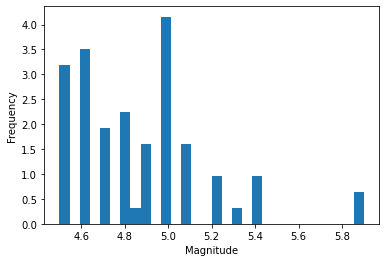

In [7]:
# Plot significant earthquakes (mag 4.5+) in a histogram

def getSignificantEarthquakes(arr):
    # init array
    sigMags = []
    for i in arr:
        if ( i.get('mag') >= 4.5):
            sigMags.append(i.get('mag'))
            
    return sigMags

significantRecords = getSignificantEarthquakes(past30DataArr)
# print(significantRecords)

x = significantRecords

plt.hist(x, density=True, bins=30)
plt.ylabel('Frequency')
plt.xlabel('Magnitude')

Text(0.5, 0, 'Magnitude')

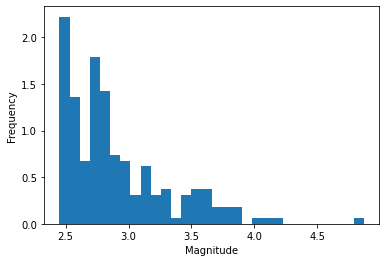

In [8]:
# Plot a histogram of only earthquakes that occurred in the US

# Read through all data and append location data
data_with_location = appendLocationData(past30DataArr)

# print(data_with_location)

# Read through each an add only those in the US to an array
def getDataForCountry(country_code, arr):
    # Init a fresh array
    magArr = []
    for i in arr:
        code = i.get('location')[0].get('country_code')
        if ( code == country_code ):
            magArr.append(i.get('mag'))
            
    
    return magArr


us_data = getDataForCountry('US', data_with_location)
# print(us_data)

x = us_data

plt.hist(x, density=True, bins=30)
plt.ylabel('Frequency')
plt.xlabel('Magnitude')